In [2]:
import numpy as np
np.bool = np.bool_ # bad trick to fix numpy version issue :(
import os
import sys
import shutil
import pickle

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

os.environ["DISPLAY"] = ":0"
os.environ["PYOPENGL_PLATFORM"] = "egl"

In [3]:
# constants
TASK = 'open_drawer'
DATA_FOLDER ='peract_colab/data'
EPISODES_FOLDER = 'colab_dataset/open_drawer/all_variations/episodes'
EPISODE_FOLDER = 'episode%d'
CAMERAS = ['front', 'left_shoulder', 'right_shoulder', 'wrist']
LOW_DIM_SIZE = 4   # {left_finger_joint, right_finger_joint, gripper_open, timestep}
IMAGE_SIZE =  128  # 128x128 - if you want to use higher voxel resolutions like 200^3, you might want to regenerate the dataset with larger images
VARIATION_DESCRIPTIONS_PKL = 'variation_descriptions.pkl' # the pkl file that contains language goals for each demonstration
EPISODE_LENGTH = 10 # max steps for agents
DEMO_AUGMENTATION_EVERY_N = 10 # sample n-th frame in demo
ROTATION_RESOLUTION = 5 # degree increments per axis

# settings
VOXEL_SIZES = [100] # 100x100x100 voxels
NUM_LATENTS = 512 # PerceiverIO latents
SCENE_BOUNDS = [-0.3, -0.5, 0.6, 0.7, 0.5, 1.6] # [x_min, y_min, z_min, x_max, y_max, z_max] - the metric volume to be voxelized
BATCH_SIZE = 1
NUM_DEMOS = 8 # total number of training demonstrations to use while training PerAct
NUM_TEST = 2 # episodes to evaluate on

In [4]:
sys.path.append('peract_colab')
data_path = os.path.join(DATA_FOLDER, EPISODES_FOLDER)

train_replay_storage_dir = 'replay_train'
if not os.path.exists(train_replay_storage_dir):
  os.mkdir(train_replay_storage_dir)

test_replay_storage_dir = 'replay_test'
if not os.path.exists(test_replay_storage_dir):
  os.mkdir(test_replay_storage_dir)

In [5]:
"""
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
RLBench Observation Class
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
"""

# from rlbench.backend.observation import Observation

class Observation(object):
    """Storage for both visual and low-dimensional observations."""

    def __init__(self,
                 left_shoulder_rgb: np.ndarray,
                 left_shoulder_depth: np.ndarray,
                 left_shoulder_mask: np.ndarray,
                 left_shoulder_point_cloud: np.ndarray,
                 right_shoulder_rgb: np.ndarray,
                 right_shoulder_depth: np.ndarray,
                 right_shoulder_mask: np.ndarray,
                 right_shoulder_point_cloud: np.ndarray,
                 overhead_rgb: np.ndarray,
                 overhead_depth: np.ndarray,
                 overhead_mask: np.ndarray,
                 overhead_point_cloud: np.ndarray,
                 wrist_rgb: np.ndarray,
                 wrist_depth: np.ndarray,
                 wrist_mask: np.ndarray,
                 wrist_point_cloud: np.ndarray,
                 front_rgb: np.ndarray,
                 front_depth: np.ndarray,
                 front_mask: np.ndarray,
                 front_point_cloud: np.ndarray,
                 joint_velocities: np.ndarray,
                 joint_positions: np.ndarray,
                 joint_forces: np.ndarray,
                 gripper_open: float,
                 gripper_pose: np.ndarray,
                 gripper_matrix: np.ndarray,
                 gripper_joint_positions: np.ndarray,
                 gripper_touch_forces: np.ndarray,
                 task_low_dim_state: np.ndarray,
                 ignore_collisions: np.ndarray,
                 misc: dict):
        self.left_shoulder_rgb = left_shoulder_rgb
        self.left_shoulder_depth = left_shoulder_depth
        self.left_shoulder_mask = left_shoulder_mask
        self.left_shoulder_point_cloud = left_shoulder_point_cloud
        self.right_shoulder_rgb = right_shoulder_rgb
        self.right_shoulder_depth = right_shoulder_depth
        self.right_shoulder_mask = right_shoulder_mask
        self.right_shoulder_point_cloud = right_shoulder_point_cloud
        self.overhead_rgb = overhead_rgb
        self.overhead_depth = overhead_depth
        self.overhead_mask = overhead_mask
        self.overhead_point_cloud = overhead_point_cloud
        self.wrist_rgb = wrist_rgb
        self.wrist_depth = wrist_depth
        self.wrist_mask = wrist_mask
        self.wrist_point_cloud = wrist_point_cloud
        self.front_rgb = front_rgb
        self.front_depth = front_depth
        self.front_mask = front_mask
        self.front_point_cloud = front_point_cloud
        self.joint_velocities = joint_velocities
        self.joint_positions = joint_positions
        self.joint_forces = joint_forces
        self.gripper_open = gripper_open
        self.gripper_pose = gripper_pose
        self.gripper_matrix = gripper_matrix
        self.gripper_joint_positions = gripper_joint_positions
        self.gripper_touch_forces = gripper_touch_forces
        self.task_low_dim_state = task_low_dim_state
        self.ignore_collisions = ignore_collisions
        self.misc = misc

    def get_low_dim_data(self) -> np.ndarray:
        """Gets a 1D array of all the low-dimensional obseervations.

        :return: 1D array of observations.
        """
        low_dim_data = [] if self.gripper_open is None else [[self.gripper_open]]
        for data in [self.joint_velocities, self.joint_positions,
                     self.joint_forces,
                     self.gripper_pose, self.gripper_joint_positions,
                     self.gripper_touch_forces, self.task_low_dim_state]:
            if data is not None:
                low_dim_data.append(data)
        return np.concatenate(low_dim_data) if len(low_dim_data) > 0 else np.array([])


In [6]:
"""
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
RLBench Backend Utilities - Extract OBS and img to float
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
"""

CAMERAS = ['front', 'left_shoulder', 'right_shoulder', 'wrist']
IMAGE_SIZE =  128

REMOVE_KEYS = ['joint_velocities', 'joint_positions', 'joint_forces',
               'gripper_open', 'gripper_pose',
               'gripper_joint_positions', 'gripper_touch_forces',
               'task_low_dim_state', 'misc']


# from rlbench.backend.utils import extract_obs
def extract_obs(obs: Observation,
				cameras,
                t: int = 0,
                prev_action = None,
                channels_last: bool = False):

    obs.joint_velocities = None
    grip_mat = obs.gripper_matrix
    grip_pose = obs.gripper_pose
    joint_pos = obs.joint_positions
    obs.gripper_pose = None
    obs.gripper_matrix = None
    obs.wrist_camera_matrix = None
    obs.joint_positions = None
    if obs.gripper_joint_positions is not None:
        obs.gripper_joint_positions = np.clip(
            obs.gripper_joint_positions, 0., 0.04)

    obs_dict = vars(obs)
    obs_dict = {k: v for k, v in obs_dict.items() if v is not None}
    robot_state = np.array([
                  obs.gripper_open,
                  *obs.gripper_joint_positions])
    
    # remove low-level proprioception variables that are not needed
    obs_dict = {k: v for k, v in obs_dict.items()
                if k not in REMOVE_KEYS}
    
    if not channels_last:
        # swap channels from last dim to 1st dim
        obs_dict = {k: np.transpose(
            v, [2, 0, 1]) if v.ndim == 3 else np.expand_dims(v, 0)
                    for k, v in obs_dict.items()}
    else:
        # add extra dim to depth data
        obs_dict = {k: v if v.ndim == 3 else np.expand_dims(v, -1)
                    for k, v in obs_dict.items()}
    obs_dict['low_dim_state'] = np.array(robot_state, dtype=np.float32)

    # binary variable indicating if collisions are allowed or not while planning paths to reach poses
    obs_dict['ignore_collisions'] = np.array([obs.ignore_collisions], dtype=np.float32)
    for (k, v) in [(k, v) for k, v in obs_dict.items() if 'point_cloud' in k]:
        obs_dict[k] = v.astype(np.float32)

    for camera_name in cameras:
          obs_dict['%s_camera_extrinsics' % camera_name] = obs.misc['%s_camera_extrinsics' % camera_name]
          obs_dict['%s_camera_intrinsics' % camera_name] = obs.misc['%s_camera_intrinsics' % camera_name]

    # add timestep to low_dim_state
    episode_length = 10 # TODO fix this
    time = (1. - (t / float(episode_length - 1))) * 2. - 1.
    obs_dict['low_dim_state'] = np.concatenate(
        [obs_dict['low_dim_state'], [time]]).astype(np.float32)

    obs.gripper_matrix = grip_mat
    obs.joint_positions = joint_pos
    obs.gripper_pose = grip_pose

    return obs_dict



# from rlbench.backend.utils import image_to_float_array
def image_to_float_array(image, scale_factor=None):
  image_array = np.array(image)
  image_dtype = image_array.dtype
  image_shape = image_array.shape

  channels = image_shape[2] if len(image_shape) > 2 else 1
  assert 2 <= len(image_shape) <= 3
  if channels == 3:
    # RGB image needs to be converted to 24 bit integer.
    float_array = np.sum(image_array * [65536, 256, 1], axis=2)
    if scale_factor is None:
      scale_factor = DEFAULT_RGB_SCALE_FACTOR
  else:
    if scale_factor is None:
      scale_factor = DEFAULT_GRAY_SCALE_FACTOR[image_dtype.type]
    float_array = image_array.astype(np.float32)
  scaled_array = float_array / scale_factor
  return scaled_array



In [7]:
"""
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
PyRep Vision Sensor Class
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
"""

# import numpy as np

class VisionSensor():
  
  @staticmethod
  def pointcloud_from_depth_and_camera_params(
          depth: np.ndarray, extrinsics: np.ndarray,
          intrinsics: np.ndarray) -> np.ndarray:
      """Converts depth (in meters) to point cloud in word frame.
      :return: A numpy array of size (width, height, 3)
      """
      upc = _create_uniform_pixel_coords_image(depth.shape)
      pc = upc * np.expand_dims(depth, -1)
      C = np.expand_dims(extrinsics[:3, 3], 0).T
      R = extrinsics[:3, :3]
      R_inv = R.T  # inverse of rot matrix is transpose
      R_inv_C = np.matmul(R_inv, C)
      extrinsics = np.concatenate((R_inv, -R_inv_C), -1)
      cam_proj_mat = np.matmul(intrinsics, extrinsics)
      cam_proj_mat_homo = np.concatenate(
          [cam_proj_mat, [np.array([0, 0, 0, 1])]])
      cam_proj_mat_inv = np.linalg.inv(cam_proj_mat_homo)[0:3]
      world_coords_homo = np.expand_dims(_pixel_to_world_coords(
          pc, cam_proj_mat_inv), 0)
      world_coords = world_coords_homo[..., :-1][0]
      return world_coords


def _transform(coords, trans):
    h, w = coords.shape[:2]
    coords = np.reshape(coords, (h * w, -1))
    coords = np.transpose(coords, (1, 0))
    transformed_coords_vector = np.matmul(trans, coords)
    transformed_coords_vector = np.transpose(
        transformed_coords_vector, (1, 0))
    return np.reshape(transformed_coords_vector,
                      (h, w, -1))


def _create_uniform_pixel_coords_image(resolution: np.ndarray):
    pixel_x_coords = np.reshape(
        np.tile(np.arange(resolution[1]), [resolution[0]]),
        (resolution[0], resolution[1], 1)).astype(np.float32)
    pixel_y_coords = np.reshape(
        np.tile(np.arange(resolution[0]), [resolution[1]]),
        (resolution[1], resolution[0], 1)).astype(np.float32)
    pixel_y_coords = np.transpose(pixel_y_coords, (1, 0, 2))
    uniform_pixel_coords = np.concatenate(
        (pixel_x_coords, pixel_y_coords, np.ones_like(pixel_x_coords)), -1)
    return uniform_pixel_coords


def _pixel_to_world_coords(pixel_coords, cam_proj_mat_inv):
    h, w = pixel_coords.shape[:2]
    pixel_coords = np.concatenate(
        [pixel_coords, np.ones((h, w, 1))], -1)
    world_coords = _transform(pixel_coords, cam_proj_mat_inv)
    world_coords_homo = np.concatenate(
        [world_coords, np.ones((h, w, 1))], axis=-1)
    return world_coords_homo





In [11]:
"""
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
RLBench Utilities  - Load Stored Demos
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
"""
# from rlbench.utils import get_stored_demo
# from pyrep.objects import VisionSensor


import os
import pickle
import numpy as np
from PIL import Image



# constants
EPISODE_FOLDER = 'episode%d'

CAMERA_FRONT = 'front'
CAMERA_LS = 'left_shoulder'
CAMERA_RS = 'right_shoulder'
CAMERA_WRIST = 'wrist'
CAMERAS = [CAMERA_FRONT, CAMERA_LS, CAMERA_RS, CAMERA_WRIST]

IMAGE_RGB = 'rgb'
IMAGE_DEPTH = 'depth'
IMAGE_TYPES = [IMAGE_RGB, IMAGE_DEPTH]
IMAGE_FORMAT  = '%d.png'
LOW_DIM_PICKLE = 'low_dim_obs.pkl'
VARIATION_NUMBER_PICKLE = 'variation_number.pkl'

DEPTH_SCALE = 2**24 - 1




def get_stored_demo(data_path, index):
  episode_path = os.path.join(data_path, EPISODE_FOLDER % index)
  
  # low dim pickle file
  with open(os.path.join(episode_path, LOW_DIM_PICKLE), 'rb') as f:
    obs = pickle.load(f)

  # variation number
  with open(os.path.join(episode_path, VARIATION_NUMBER_PICKLE), 'rb') as f:
    obs.variation_number = pickle.load(f)

  num_steps = len(obs)
  for i in range(num_steps):
    obs[i].front_rgb = np.array(Image.open(os.path.join(episode_path, '%s_%s' % (CAMERA_FRONT, IMAGE_RGB), IMAGE_FORMAT % i)))
    obs[i].left_shoulder_rgb = np.array(Image.open(os.path.join(episode_path, '%s_%s' % (CAMERA_LS, IMAGE_RGB), IMAGE_FORMAT % i)))
    obs[i].right_shoulder_rgb = np.array(Image.open(os.path.join(episode_path, '%s_%s' % (CAMERA_RS, IMAGE_RGB), IMAGE_FORMAT % i)))
    obs[i].wrist_rgb = np.array(Image.open(os.path.join(episode_path, '%s_%s' % (CAMERA_WRIST, IMAGE_RGB), IMAGE_FORMAT % i)))

    obs[i].front_depth = image_to_float_array(Image.open(os.path.join(episode_path, '%s_%s' % (CAMERA_FRONT, IMAGE_DEPTH), IMAGE_FORMAT % i)), DEPTH_SCALE)
    near = obs[i].misc['%s_camera_near' % (CAMERA_FRONT)]
    far = obs[i].misc['%s_camera_far' % (CAMERA_FRONT)]
    obs[i].front_depth = near + obs[i].front_depth * (far - near)

    obs[i].left_shoulder_depth = image_to_float_array(Image.open(os.path.join(episode_path, '%s_%s' % (CAMERA_LS, IMAGE_DEPTH), IMAGE_FORMAT % i)), DEPTH_SCALE)
    near = obs[i].misc['%s_camera_near' % (CAMERA_LS)]
    far = obs[i].misc['%s_camera_far' % (CAMERA_LS)]
    obs[i].left_shoulder_depth = near + obs[i].left_shoulder_depth * (far - near)

    obs[i].right_shoulder_depth = image_to_float_array(Image.open(os.path.join(episode_path, '%s_%s' % (CAMERA_RS, IMAGE_DEPTH), IMAGE_FORMAT % i)), DEPTH_SCALE)
    near = obs[i].misc['%s_camera_near' % (CAMERA_RS)]
    far = obs[i].misc['%s_camera_far' % (CAMERA_RS)]
    obs[i].right_shoulder_depth = near + obs[i].right_shoulder_depth * (far - near)

    obs[i].wrist_depth = image_to_float_array(Image.open(os.path.join(episode_path, '%s_%s' % (CAMERA_WRIST, IMAGE_DEPTH), IMAGE_FORMAT % i)), DEPTH_SCALE)
    near = obs[i].misc['%s_camera_near' % (CAMERA_WRIST)]
    far = obs[i].misc['%s_camera_far' % (CAMERA_WRIST)]
    obs[i].wrist_depth = near + obs[i].wrist_depth * (far - near)

    obs[i].front_point_cloud = VisionSensor.pointcloud_from_depth_and_camera_params(obs[i].front_depth, 
                                                                                    obs[i].misc['front_camera_extrinsics'],
                                                                                    obs[i].misc['front_camera_intrinsics'])
    obs[i].left_shoulder_point_cloud = VisionSensor.pointcloud_from_depth_and_camera_params(obs[i].left_shoulder_depth, 
                                                                                            obs[i].misc['left_shoulder_camera_extrinsics'],
                                                                                            obs[i].misc['left_shoulder_camera_intrinsics'])
    obs[i].right_shoulder_point_cloud = VisionSensor.pointcloud_from_depth_and_camera_params(obs[i].right_shoulder_depth, 
                                                                                             obs[i].misc['right_shoulder_camera_extrinsics'],
                                                                                             obs[i].misc['right_shoulder_camera_intrinsics'])
    obs[i].wrist_point_cloud = VisionSensor.pointcloud_from_depth_and_camera_params(obs[i].wrist_depth, 
                                                                                           obs[i].misc['wrist_camera_extrinsics'],
                                                                                           obs[i].misc['wrist_camera_intrinsics'])
    
  return obs

In [12]:
# visualize



# what to visualize
episode_idx_to_visualize = 1 # out of 10 demos
ts = 50 # timestep out of total timesteps

# get demo
demo = get_stored_demo(data_path=data_path,
                      index=episode_idx_to_visualize)

# extract obs at timestep
obs_dict = extract_obs(demo._observations[ts], CAMERAS, t=ts)

# total timesteps in demo
print(f"Demo {episode_idx_to_visualize} | {len(demo._observations)} total steps\n")

# plot rgb and depth at timestep
fig = plt.figure(figsize=(20, 10))
rows, cols = 2, len(CAMERAS)

plot_idx = 1
for camera in CAMERAS:
  # rgb
  rgb_name = "%s_%s" % (camera, 'rgb')
  rgb = np.transpose(obs_dict[rgb_name], (1, 2, 0))
  fig.add_subplot(rows, cols, plot_idx)
  plt.imshow(rgb)
  plt.axis('off')
  plt.title("%s_rgb | step %s" % (camera, ts))

  # depth
  depth_name = "%s_%s" % (camera, 'depth')
  depth = np.transpose(obs_dict[depth_name], (1, 2, 0)).reshape(IMAGE_SIZE, IMAGE_SIZE)
  fig.add_subplot(rows, cols, plot_idx+len(CAMERAS))
  plt.imshow(depth)
  plt.axis('off')
  plt.title("%s_depth | step %s" % (camera, ts))

  plot_idx += 1

plt.show()

In [13]:
"""
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Voxel Grid Class
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
"""


from functools import reduce as funtool_reduce
from operator import mul

import torch
from torch import nn, einsum
import torch.nn.functional as F

MIN_DENOMINATOR = 1e-12
INCLUDE_PER_VOXEL_COORD = True

# from main tutorial 
class VoxelGrid(nn.Module):

    def __init__(self,
                 coord_bounds,
                 voxel_size: int,
                 device,
                 batch_size,
                 feature_size,
                 max_num_coords: int,):
        super(VoxelGrid, self).__init__()
        self._device = device
        self._voxel_size = voxel_size
        self._voxel_shape = [voxel_size] * 3
        self._voxel_d = float(self._voxel_shape[-1])
        self._voxel_feature_size = 4 + feature_size
        self._voxel_shape_spec = torch.tensor(self._voxel_shape,
                                              device=device).unsqueeze(
            0) + 2  # +2 because we crop the edges.
        self._coord_bounds = torch.tensor(coord_bounds, dtype=torch.float,
                                          device=device).unsqueeze(0)
        max_dims = self._voxel_shape_spec[0]
        self._total_dims_list = torch.cat(
            [torch.tensor([batch_size], device=device), max_dims,
             torch.tensor([4 + feature_size], device=device)], -1).tolist()
        self._ones_max_coords = torch.ones((batch_size, max_num_coords, 1),
                                           device=device)
        self._num_coords = max_num_coords

        shape = self._total_dims_list

        self._result_dim_sizes = torch.tensor(
            [funtool_reduce(mul, shape[i + 1:], 1) for i in range(len(shape) - 1)] + [
                1], device=device)
        flat_result_size = funtool_reduce(mul, shape, 1)

        self._initial_val = torch.tensor(0, dtype=torch.float,
                                         device=device)
        self._flat_output = torch.ones(flat_result_size, dtype=torch.float,
                                       device=device) * self._initial_val
        self._arange_to_max_coords = torch.arange(4 + feature_size,
                                                  device=device)
        self._flat_zeros = torch.zeros(flat_result_size, dtype=torch.float,
                                       device=device)

        self._const_1 = torch.tensor(1.0, device=device)
        self._batch_size = batch_size

        # Coordinate Bounds:
        self._bb_mins = self._coord_bounds[..., 0:3]
        bb_maxs = self._coord_bounds[..., 3:6]
        bb_ranges = bb_maxs - self._bb_mins
        # get voxel dimensions. 'DIMS' mode
        self._dims = dims = self._voxel_shape_spec.int()
        self._dims_orig = dims_orig = self._voxel_shape_spec.int() - 2
        self._dims_m_one = (dims - 1).int()
        # BS x 1 x 3
        self._res = bb_ranges / (dims_orig.float() + MIN_DENOMINATOR)
        self._res_minis_2 = bb_ranges / (dims.float() - 2 + MIN_DENOMINATOR)

        self._voxel_indicy_denmominator = self._res + MIN_DENOMINATOR
        self._dims_m_one_zeros = torch.zeros_like(self._dims_m_one)

        batch_indices = torch.arange(self._batch_size, dtype=torch.int,
                                     device=device).view(self._batch_size, 1, 1)
        self._tiled_batch_indices = batch_indices.repeat(
            [1, self._num_coords, 1])

        w = self._voxel_shape[0] + 2
        arange = torch.arange(0, w, dtype=torch.float, device=device)
        self._index_grid = torch.cat([
            arange.view(w, 1, 1, 1).repeat([1, w, w, 1]),
            arange.view(1, w, 1, 1).repeat([w, 1, w, 1]),
            arange.view(1, 1, w, 1).repeat([w, w, 1, 1])], dim=-1).unsqueeze(
            0).repeat([self._batch_size, 1, 1, 1, 1])

    def _broadcast(self, src: torch.Tensor, other: torch.Tensor, dim: int):
        if dim < 0:
            dim = other.dim() + dim
        if src.dim() == 1:
            for _ in range(0, dim):
                src = src.unsqueeze(0)
        for _ in range(src.dim(), other.dim()):
            src = src.unsqueeze(-1)
        src = src.expand_as(other)
        return src

    def _scatter_mean(self, src: torch.Tensor, index: torch.Tensor, out: torch.Tensor,
                      dim: int = -1):
        out = out.scatter_add_(dim, index, src)

        index_dim = dim
        if index_dim < 0:
            index_dim = index_dim + src.dim()
        if index.dim() <= index_dim:
            index_dim = index.dim() - 1

        ones = torch.ones(index.size(), dtype=src.dtype, device=src.device)
        out_count = torch.zeros(out.size(), dtype=out.dtype, device=out.device)
        out_count = out_count.scatter_add_(index_dim, index, ones)
        out_count.clamp_(1)
        count = self._broadcast(out_count, out, dim)
        if torch.is_floating_point(out):
            out.true_divide_(count)
        else:
            out.floor_divide_(count)
        return out

    def _scatter_nd(self, indices, updates):
        indices_shape = indices.shape
        num_index_dims = indices_shape[-1]
        flat_updates = updates.view((-1,))
        indices_scales = self._result_dim_sizes[0:num_index_dims].view(
            [1] * (len(indices_shape) - 1) + [num_index_dims])
        indices_for_flat_tiled = ((indices * indices_scales).sum(
            dim=-1, keepdims=True)).view(-1, 1).repeat(
            *[1, self._voxel_feature_size])

        implicit_indices = self._arange_to_max_coords[
                           :self._voxel_feature_size].unsqueeze(0).repeat(
            *[indices_for_flat_tiled.shape[0], 1])
        indices_for_flat = indices_for_flat_tiled + implicit_indices
        flat_indices_for_flat = indices_for_flat.view((-1,)).long()

        flat_scatter = self._scatter_mean(
            flat_updates, flat_indices_for_flat,
            out=torch.zeros_like(self._flat_output))
        return flat_scatter.view(self._total_dims_list)

    def coords_to_bounding_voxel_grid(self, coords, coord_features=None,
                                      coord_bounds=None):
        voxel_indicy_denmominator = self._voxel_indicy_denmominator
        res, bb_mins = self._res, self._bb_mins
        if coord_bounds is not None:
            bb_mins = coord_bounds[..., 0:3]
            bb_maxs = coord_bounds[..., 3:6]
            bb_ranges = bb_maxs - bb_mins
            res = bb_ranges / (self._dims_orig.float() + MIN_DENOMINATOR)
            voxel_indicy_denmominator = res + MIN_DENOMINATOR

        bb_mins_shifted = bb_mins - res  # shift back by one
        floor = torch.floor(
            (coords - bb_mins_shifted.unsqueeze(1)) / voxel_indicy_denmominator.unsqueeze(1)).int()
        voxel_indices = torch.min(floor, self._dims_m_one)
        voxel_indices = torch.max(voxel_indices, self._dims_m_one_zeros)

        # global-coordinate point cloud (x, y, z)
        voxel_values = coords

        # rgb values (R, G, B)
        if coord_features is not None:
            voxel_values = torch.cat([voxel_values, coord_features], -1) # concat rgb values (B, 128, 128, 3)

        # coordinates to aggregate over
        _, num_coords, _ = voxel_indices.shape
        all_indices = torch.cat([
            self._tiled_batch_indices[:, :num_coords], voxel_indices], -1)

        # max coordinates
        voxel_values_pruned_flat = torch.cat(
            [voxel_values, self._ones_max_coords[:, :num_coords]], -1)

        # aggregate across camera views
        scattered = self._scatter_nd(
            all_indices.view([-1, 1 + 3]),
            voxel_values_pruned_flat.view(-1, self._voxel_feature_size))

        vox = scattered[:, 1:-1, 1:-1, 1:-1]
        if INCLUDE_PER_VOXEL_COORD:
            res_expanded = res.unsqueeze(1).unsqueeze(1).unsqueeze(1)
            res_centre = (res_expanded * self._index_grid) + res_expanded / 2.0
            coord_positions = (res_centre + bb_mins_shifted.unsqueeze(
                1).unsqueeze(1).unsqueeze(1))[:, 1:-1, 1:-1, 1:-1]
            vox = torch.cat([vox[..., :-1], coord_positions, vox[..., -1:]], -1)

        # occupied value
        occupied = (vox[..., -1:] > 0).float()
        vox = torch.cat([
            vox[..., :-1], occupied], -1)

        # hard voxel-location position encoding
        return torch.cat(
           [vox[..., :-1], self._index_grid[:, :-2, :-2, :-2] / self._voxel_d,
            vox[..., -1:]], -1)


In [18]:
"""
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
ARM utilities
    - normalize_quaternion
    - quaternion_to_discrete_euler
    - discrete_euler_to_quaternion
    - point_to_voxel_index
    - stack_on_channel
    - _compute_initial_camera_pose
    - _from_trimesh_scene
    - create_voxel_scene
    - visualise_voxel
    - get_gripper_render_pose
    - _norm_rgb
    - _preprocess_inputs
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
"""

# from arm.utils import *

# Adapted from: https://github.com/stepjam/ARM/blob/main/arm/utils.py

import torch
# import numpy as np
from scipy.spatial.transform import Rotation

import pyrender
import trimesh
from pyrender.trackball import Trackball



def normalize_quaternion(quat):
    return np.array(quat) / np.linalg.norm(quat, axis=-1, keepdims=True)


def quaternion_to_discrete_euler(quaternion, resolution):
    euler = Rotation.from_quat(quaternion).as_euler('xyz', degrees=True) + 180
    assert np.min(euler) >= 0 and np.max(euler) <= 360
    disc = np.around((euler / resolution)).astype(int)
    disc[disc == int(360 / resolution)] = 0
    return disc


def discrete_euler_to_quaternion(discrete_euler, resolution):
    euluer = (discrete_euler * resolution) - 180
    return Rotation.from_euler('xyz', euluer, degrees=True).as_quat()


def point_to_voxel_index(
        point: np.ndarray,
        voxel_size: np.ndarray,
        coord_bounds: np.ndarray):
    bb_mins = np.array(coord_bounds[0:3])
    bb_maxs = np.array(coord_bounds[3:])
    dims_m_one = np.array([voxel_size] * 3) - 1
    bb_ranges = bb_maxs - bb_mins
    res = bb_ranges / (np.array([voxel_size] * 3) + 1e-12)
    voxel_indicy = np.minimum(
        np.floor((point - bb_mins) / (res + 1e-12)).astype(
            np.int32), dims_m_one)
    return voxel_indicy


def stack_on_channel(x):
    # expect (B, T, C, ...)
    return torch.cat(torch.split(x, 1, dim=1), dim=2).squeeze(1)


def _compute_initial_camera_pose(scene):
    # Adapted from:
    # https://github.com/mmatl/pyrender/blob/master/pyrender/viewer.py#L1032
    centroid = scene.centroid
    scale = scene.scale
    # if scale == 0.0:
    #     scale = DEFAULT_SCENE_SCALE
    scale = 4.0
    s2 = 1.0 / np.sqrt(2.0)
    cp = np.eye(4)
    cp[:3, :3] = np.array([[0.0, -s2, s2], [1.0, 0.0, 0.0], [0.0, s2, s2]])
    hfov = np.pi / 6.0
    dist = scale / (2.0 * np.tan(hfov))
    cp[:3, 3] = dist * np.array([1.0, 0.0, 1.0]) + centroid
    return cp


def _from_trimesh_scene(
        trimesh_scene, bg_color=None, ambient_light=None):
    # convert trimesh geometries to pyrender geometries
    geometries = {name: pyrender.Mesh.from_trimesh(geom, smooth=False)
                  for name, geom in trimesh_scene.geometry.items()}
    # create the pyrender scene object
    scene_pr = pyrender.Scene(bg_color=bg_color, ambient_light=ambient_light)
    # add every node with geometry to the pyrender scene
    for node in trimesh_scene.graph.nodes_geometry:
        pose, geom_name = trimesh_scene.graph[node]
        scene_pr.add(geometries[geom_name], pose=pose)
    return scene_pr


def create_voxel_scene(
        voxel_grid: np.ndarray,
        q_attention: np.ndarray = None,
        highlight_coordinate: np.ndarray = None,
        highlight_gt_coordinate: np.ndarray = None,
        highlight_alpha: float = 1.0,
        voxel_size: float = 0.1,
        show_bb: bool = False,
        alpha: float = 0.5):
    _, d, h, w = voxel_grid.shape
    v = voxel_grid.transpose((1, 2, 3, 0))
    occupancy = v[:, :, :, -1] != 0
    alpha = np.expand_dims(np.full_like(occupancy, alpha, dtype=np.float32), -1)
    rgb = np.concatenate([(v[:, :, :, 3:6] + 1)/ 2.0, alpha], axis=-1)

    if q_attention is not None:
        q = np.max(q_attention, 0)
        q = q / np.max(q)
        show_q = (q > 0.75)
        occupancy = (show_q + occupancy).astype(bool)
        q = np.expand_dims(q - 0.5, -1)  # Max q can be is 0.9
        q_rgb = np.concatenate([
            q, np.zeros_like(q), np.zeros_like(q),
            np.clip(q, 0, 1)], axis=-1)
        rgb = np.where(np.expand_dims(show_q, -1), q_rgb, rgb)

    if highlight_coordinate is not None:
        x, y, z = highlight_coordinate
        occupancy[x, y, z] = True
        rgb[x, y, z] = [1.0, 0.0, 0.0, highlight_alpha]

    if highlight_gt_coordinate is not None:
        x, y, z = highlight_gt_coordinate
        occupancy[x, y, z] = True
        rgb[x, y, z] = [0.0, 0.0, 1.0, highlight_alpha]

    transform = trimesh.transformations.scale_and_translate(
        scale=voxel_size, translate=(0.0, 0.0, 0.0))
    trimesh_voxel_grid = trimesh.voxel.VoxelGrid(
        encoding=occupancy, transform=transform)
    geometry = trimesh_voxel_grid.as_boxes(colors=rgb)
    scene = trimesh.Scene()
    scene.add_geometry(geometry)
    if show_bb:
        assert d == h == w
        _create_bounding_box(scene, voxel_size, d)
    return scene


def visualise_voxel(voxel_grid: np.ndarray,
                    q_attention: np.ndarray = None,
                    highlight_coordinate: np.ndarray = None,
                    highlight_gt_coordinate: np.ndarray = None,
                    highlight_alpha: float = 1.0,
                    rotation_amount: float = 0.0,
                    show: bool = False,
                    voxel_size: float = 0.1,
                    offscreen_renderer: pyrender.OffscreenRenderer = None,
                    show_bb: bool = False,
                    alpha: float = 0.5,
                    render_gripper=False,
                    gripper_pose=None,
                    gripper_mesh_scale=1.0):
    scene = create_voxel_scene(
        voxel_grid, q_attention, highlight_coordinate, highlight_gt_coordinate,
        highlight_alpha, voxel_size,
        show_bb, alpha)
    if show:
        scene.show()
    else:
        r = offscreen_renderer or pyrender.OffscreenRenderer(
            viewport_width=1920, viewport_height=1080, point_size=1.0)
        s = _from_trimesh_scene(
            scene, ambient_light=[0.8, 0.8, 0.8],
            bg_color=[1.0, 1.0, 1.0])
        cam = pyrender.PerspectiveCamera(
            yfov=np.pi / 4.0, aspectRatio=r.viewport_width/r.viewport_height)
        p = _compute_initial_camera_pose(s)
        t = Trackball(p, (r.viewport_width, r.viewport_height), s.scale, s.centroid)
        t.rotate(rotation_amount, np.array([0.0, 0.0, 1.0]))
        s.add(cam, pose=t.pose)

        if render_gripper:
            gripper_trimesh = trimesh.load('peract_colab/meshes/hand.dae', force='mesh')
            gripper_trimesh.vertices *= gripper_mesh_scale
            radii = np.linalg.norm(gripper_trimesh.vertices - gripper_trimesh.center_mass, axis=1)
            gripper_trimesh.visual.vertex_colors = trimesh.visual.interpolate(radii * gripper_mesh_scale, color_map='winter')
            gripper_mesh = pyrender.Mesh.from_trimesh(gripper_trimesh, poses=np.array([gripper_pose]), smooth=False)
            s.add(gripper_mesh) 
        color, depth = r.render(s)
        return color.copy()


def get_gripper_render_pose(voxel_scale, scene_bound_origin, continuous_trans, continuous_quat):
	# finger tip to gripper offset
	offset = np.array([[1, 0, 0, 0],
	                   [0, 1, 0, 0],
	                   [0, 0, 1, 0.1*voxel_scale],
	                   [0, 0, 0, 1]])

	# scale and translate by origin
	translation = (continuous_trans - (np.array(scene_bound_origin[:3]))) * voxel_scale
	mat = np.eye(4,4)
	mat[:3,:3] = Rotation.from_quat([continuous_quat[0], continuous_quat[1], continuous_quat[2], continuous_quat[3]]).as_matrix()
	offset_mat = np.matmul(mat, offset)
	mat[:3,3] = translation - offset_mat[:3,3]
	return mat


# from main tutorial 
def _norm_rgb(x):
    return (x.float() / 255.0) * 2.0 - 1.0

def _preprocess_inputs(replay_sample):
    obs, pcds = [], []
    for n in CAMERAS:
        rgb = stack_on_channel(replay_sample['%s_rgb' % n])
        pcd = stack_on_channel(replay_sample['%s_point_cloud' % n])

        rgb = _norm_rgb(rgb)

        obs.append([rgb, pcd]) # obs contains both rgb and pointcloud (used in ARM for other baselines)
        pcds.append(pcd) # only pointcloud
    return obs, pcds


In [19]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [32]:
vox_grid = VoxelGrid(
    coord_bounds=SCENE_BOUNDS,
    voxel_size=VOXEL_SIZES[0],
    device=device,
    batch_size=BATCH_SIZE,
    feature_size=3,
    max_num_coords=np.prod([IMAGE_SIZE, IMAGE_SIZE]) * len(CAMERAS),
)

In [36]:
def create_batch_from_obs_dict(obs_dict:dict):
    tmp = {k: torch.tensor(v).unsqueeze(0).unsqueeze(0) \
        for k,v in obs_dict.items()}
    return tmp

batch = create_batch_from_obs_dict(obs_dict)

In [38]:

batch = {k: v.to(device) for k, v in batch.items() if type(v) == torch.Tensor}
obs, pcds = _preprocess_inputs(batch)

# flatten observations
bs = obs[0][0].shape[0]
pcd_flat = torch.cat([p.permute(0, 2, 3, 1).reshape(bs, -1, 3) for p in pcds], 1)

image_features = [o[0] for o in obs]
feat_size = image_features[0].shape[1]
flat_imag_features = torch.cat(
    [p.permute(0, 2, 3, 1).reshape(bs, -1, feat_size) for p in image_features], 1)

# tensorize scene bounds
bounds = torch.tensor(SCENE_BOUNDS, device=device).unsqueeze(0)

# voxelize!
voxel_grid = vox_grid.coords_to_bounding_voxel_grid(pcd_flat,
                                                    coord_features=flat_imag_features,
                                                    coord_bounds=bounds)

# swap to channels fist
vis_voxel_grid = voxel_grid.permute(0, 4, 1, 2, 3).detach().cpu().numpy()

(-0.5, 1919.5, 1079.5, -0.5)

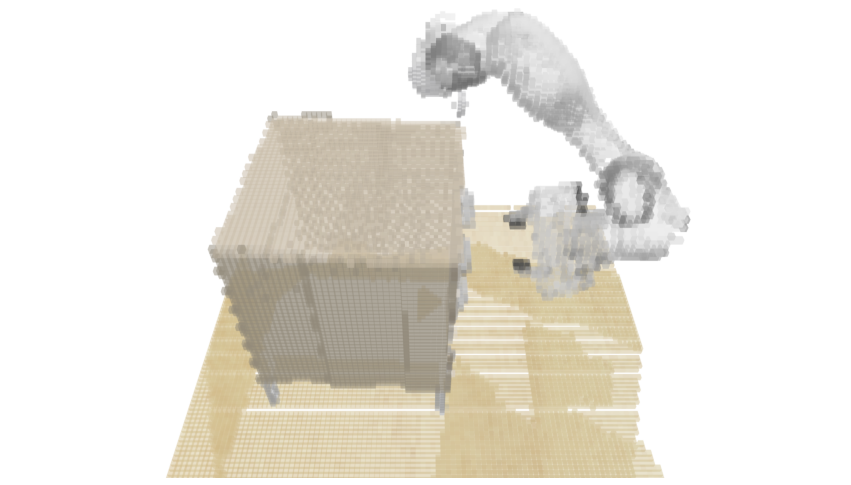

In [40]:
# render voxel grid with expert action (blue)
#@markdown #### Show voxel grid and expert action (blue)
#@markdown Adjust `rotation_amount` to change the camera yaw angle for rendering.
rotation_amount = 0 #@param {type:"slider", min:-180, max:180, step:5}
rendered_img = visualise_voxel(vis_voxel_grid[0],
                               None,
                               None,
                               None,
                               voxel_size=0.045,
                               rotation_amount=np.deg2rad(rotation_amount))

fig = plt.figure(figsize=(15, 15))
plt.imshow(rendered_img)
plt.axis('off')
